<a href="https://colab.research.google.com/github/ElKev118/Intro_ML_project/blob/main/RegresionLogistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebook se entrenará un modelo de Regresión Logística para la detección de fraude bancario.
Los datos ya han sido preprocesados previamente, incluyendo escalado y división en conjuntos de entrenamiento y prueba.
A partir de este punto, el dataset está completamente listo para entrenar, validar y evaluar el modelo utilizando métricas de clasificación adecuadas para problemas de fraude.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import requests
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score,precision_score,recall_score,f1_score, matthews_corrcoef,roc_auc_score,balanced_accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
import time
import pandas as pd

In [3]:
X_train = pd.read_csv('/content/drive/MyDrive/485/X_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/485/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/485/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/485/y_test.csv')

Esta función entrena un modelo de regresión logistica usando Stratified K-Fold y SMOTE sobre el conjunto de entrenamiento. En cada fold calcula las métricas de entrenamiento y validación (accuracy, precisión, recall, F1, MCC, ROC-AUC y balanced accuracy) y promedia los resultados. Después entrena un modelo final con todo el conjunto de entrenamiento y lo evalúa en el conjunto de test, obteniendo las mismas métricas y la matriz de confusión.

In [10]:
def entrenamiento_sin_seleccion_caracteristicas(X_train, X_test, y_train, y_test, splits,hiperparametros=None):
    """
    Función que ejecuta el entrenamiento del modelo sin una selección particular
    de las características

      Parámetros:
        X: matriz con las características
        Y: Matriz con la variable objetivo
        splits : número de particiones  a realizar

      Retorna:
        DataFrame con las métricas de entrenamiento, validación y test
    """
    X_train = np.asarray(X_train)
    X_test  = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test  = np.asarray(y_test)

    if hiperparametros is None:
        hiperparametros = {"max_iter": 500}

    j = 0
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    Errores = np.zeros(splits)
    times = np.zeros(splits)

    acc_train = np.zeros(splits)
    prec_train = np.zeros(splits)
    rec_train = np.zeros(splits)
    f1_train = np.zeros(splits)
    mcc_train = np.zeros(splits)
    roc_train = np.zeros(splits)
    blacc_train= np.zeros(splits)

    acc_val = np.zeros(splits)
    prec_val = np.zeros(splits)
    rec_val = np.zeros(splits)
    f1_val = np.zeros(splits)
    mcc_val = np.zeros(splits)
    roc_val = np.zeros(splits)
    blacc_val= np.zeros(splits)


    n_clases = len(np.unique(y_train))

    for train_index, test_index in kf.split(X_train, y_train):
        X_train_train, X_validation = X_train[train_index], X_train[test_index]
        y_train_train, y_validation = y_train[train_index], y_train[test_index]

        # Escalado
        scaler = StandardScaler()
        X_train_scaler = scaler.fit_transform(X_train_train)
        X_validation_scaler = scaler.transform(X_validation)

        #Aplicación SMOTE
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train_scaler, y_train_train)

        # Clasificador logistic regresion
        model = LogisticRegression(**hiperparametros)

         # Para calcular el costo computacional
        tiempo_i = time.time()

        # Entrenamiento el modelo.
        model.fit(X_train_res, y_train_res)

        tiempo_f = time.time()
        times[j] = tiempo_f - tiempo_i

        # Probabilidades para ROC-AUC
        y_train_proba = model.predict_proba(X_train_scaler)
        y_val_proba   = model.predict_proba(X_validation_scaler)

        # Métricas TRAIN (sobre train original escalado) ----
        y_train_pred = model.predict(X_train_scaler)
        acc_train[j]  = accuracy_score(y_train_train, y_train_pred)
        prec_train[j] = precision_score(y_train_train, y_train_pred, average='weighted', zero_division=0)
        rec_train[j]  = recall_score(y_train_train, y_train_pred, average='weighted', zero_division=0)
        f1_train[j]   = f1_score(y_train_train, y_train_pred, average='weighted', zero_division=0)
        mcc_train[j]  = matthews_corrcoef(y_train_train, y_train_pred)

        if n_clases > 2:
            roc_train[j] = roc_auc_score(y_train_train, y_train_proba, multi_class='ovr', average='weighted')
        else:
            roc_train[j] = roc_auc_score(y_train_train, y_train_proba[:, 1])
        blacc_train[j] = balanced_accuracy_score(y_train_train, y_train_pred)


        # Métricas VALIDACIÓN (fold) ----
        y_val_pred = model.predict(X_validation_scaler)
        acc_val[j]  = accuracy_score(y_validation, y_val_pred)
        prec_val[j] = precision_score(y_validation, y_val_pred, average='weighted', zero_division=0)
        rec_val[j]  = recall_score(y_validation, y_val_pred, average='weighted', zero_division=0)
        f1_val[j]   = f1_score(y_validation, y_val_pred, average='weighted', zero_division=0)
        mcc_val[j]  = matthews_corrcoef(y_validation, y_val_pred)

        if n_clases > 2:
            roc_val[j] = roc_auc_score(y_validation, y_val_proba,multi_class='ovr', average='weighted')
        else:
            roc_val[j] = roc_auc_score(y_validation, y_val_proba[:, 1])
        blacc_val[j] = balanced_accuracy_score(y_validation, y_val_pred)

        j += 1
    metrics_train = {
        "accuracy":  acc_train.mean(),
        "precision": prec_train.mean(),
        "recall":    rec_train.mean(),
        "f1":        f1_train.mean(),
        "mcc":       mcc_train.mean(),
        "roc_auc":   roc_train.mean(),
        "balance_accuracy":     blacc_train.mean()
    }
    metrics_train["error"] = 1.0 - metrics_train["accuracy"]

    metrics_val = {
        "accuracy":  acc_val.mean(),
        "precision": prec_val.mean(),
        "recall":    rec_val.mean(),
        "f1":        f1_val.mean(),
        "mcc":       mcc_val.mean(),
        "roc_auc":   roc_val.mean(),
        "balance_accuracy":     blacc_val.mean()
    }
    metrics_val["error"] = 1.0 - metrics_val["accuracy"]

    tiempo_medio = times.mean()


    # ENTRENAR MODELO FINAL Y EVALUAR EN TEST
    scaler_final = StandardScaler()
    X_train_final = scaler_final.fit_transform(X_train)
    X_test_final = scaler_final.transform(X_test)

    smote_final = SMOTE(random_state=42)
    X_train_final, y_train_final = smote_final.fit_resample(X_train_final, y_train)

    model_final = LogisticRegression(**hiperparametros)
    model_final.fit(X_train_final, y_train_final)

    y_test_pred = model_final.predict(X_test_final)

    y_test_pred  = model_final.predict(X_test_final)
    y_test_proba = model_final.predict_proba(X_test_final)

    # Matrix confucion
    cm_test = confusion_matrix(y_test, y_test_pred)

    if n_clases > 2:
        roc_test = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')
    else:
        roc_test = roc_auc_score(y_test, y_test_proba[:, 1])

    metrics_test = {
    "accuracy":  accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
    "recall":    recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
    "f1":        f1_score(y_test, y_test_pred, average='weighted', zero_division=0),
    "mcc":       matthews_corrcoef(y_test, y_test_pred),
    "roc_auc":   roc_test,
    "balance_accuracy":     balanced_accuracy_score(y_test, y_test_pred)
    }
    metrics_test["error"] = 1.0 - metrics_test["accuracy"]

    # DataFrame con filas: entrenamiento, validación, test
    metrics_df = pd.DataFrame([
        {"fase": "entrenamiento", **metrics_train},
        {"fase": "validacion",    **metrics_val},
        {"fase": "test",          **metrics_test},
    ]).set_index("fase")

    return metrics_df, tiempo_medio, cm_test

Hiperparametros  

In [6]:
param_grid = [
    {"C": c, "penalty": "l2", "solver": "lbfgs", "max_iter": mx}
    for c in [0.01, 0.1, 1, 10]
    for mx in [100,300,500,1000]
]

Esta función realiza una búsqueda de hiperparámetros para la regresión logistica.
Para cada combinación en param_grid:

Llama a entrenamiento_sin_seleccion_caracteristicas,

Extrae las métricas de validación (F1 y balanced accuracy),

Guarda los resultados junto con los hiperparámetros probados.

Después construye un DataFrame con todas las combinaciones y selecciona los mejores hiperparámetros según la mayor balanced accuracy en validación.

In [8]:
def seleccion_mejores_hiperparametros(X_train, X_test, y_train, y_test, splits, param_grid):
    resultados = []

    for params in param_grid:
        df_metrics, t_med, cm_test = entrenamiento_sin_seleccion_caracteristicas(X_train, X_test, y_train, y_test,splits=splits,hiperparametros=params)

        resultados.append({
            "params":         params,
            "f1_validacion":  df_metrics.loc["validacion", "f1"],
            "balance_accuracy":  df_metrics.loc["validacion", "balance_accuracy"]
        })

    resultados_df = pd.DataFrame(resultados)

    mejor = resultados_df.sort_values("balance_accuracy", ascending=False).iloc[0]
    mejores_hiperparametros = mejor["params"]

    return mejores_hiperparametros



Entrenamiento del modelo con los mejores Hiperparametros

In [11]:
mejores_params = seleccion_mejores_hiperparametros(X_train, X_test, y_train, y_test,splits=5,param_grid=param_grid)
metrics_df, t_med,cm_test = entrenamiento_sin_seleccion_caracteristicas(X_train, X_test, y_train, y_test,5,mejores_params)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gráfica de rendimiento por fase de entrenamiento, validación y prueba

<Figure size 1000x700 with 0 Axes>

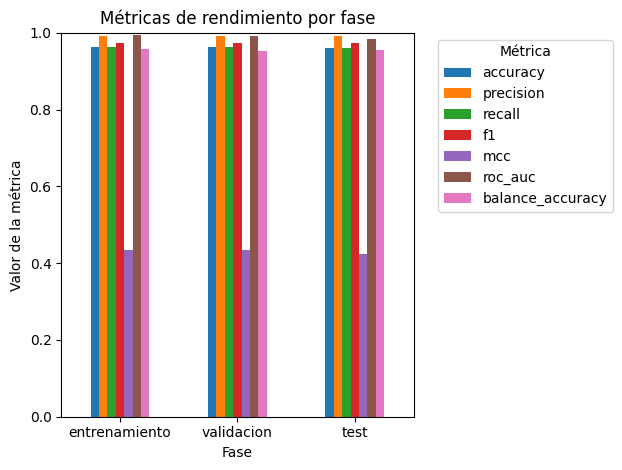

In [12]:
import matplotlib.pyplot as plt

metricas = ["accuracy", "precision", "recall", "f1", "mcc", "roc_auc","balance_accuracy"]
plt.figure(figsize=(10, 7))
metrics_df[metricas].plot(kind="bar")
plt.ylim(0, 1)
plt.xlabel("Fase")
plt.ylabel("Valor de la métrica")
plt.title("Métricas de rendimiento por fase")
plt.xticks(rotation=0)
plt.legend(title="Métrica", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Gráfica de métricas por fase de entrenamiento, validación y test

In [14]:
tabla = metrics_df.round(4).reset_index()
tabla.style.set_properties(**{'background-color': 'white','color': 'black','border': '1px solid #ccc'})

,fase,accuracy,precision,recall,f1,mcc,roc_auc,balance_accuracy,error
0,entrenamiento,0.963000,0.991600,0.963000,0.974500,0.435400,0.994500,0.958100,0.037000
1,validacion,0.963300,0.991500,0.963300,0.974700,0.433100,0.992700,0.953600,0.036700
2,test,0.961000,0.991500,0.961000,0.973400,0.424100,0.984300,0.955600,0.039000


Matriz de confusión para test

<Figure size 800x600 with 0 Axes>

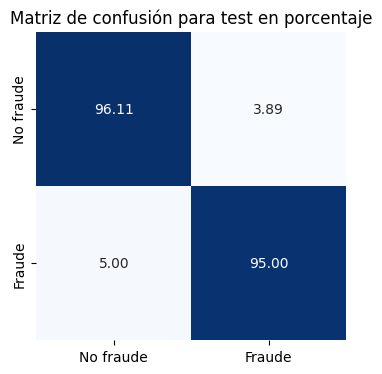

In [17]:
import seaborn as sns
plt.figure(figsize=(8, 6))


label_map = {0: "No fraude", 1: "Fraude"}
clases = [label_map[c] for c in np.unique(y_test)]

cm_normalized =( cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis])*100
plt.figure(figsize=(4, 4))
sns.heatmap(cm_normalized,annot=True,fmt='.2f',cmap='Blues',xticklabels=clases,yticklabels=clases,cbar=False)

plt.title("Matriz de confusión para test en porcentaje")

plt.show()